In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mpl_colors
import matplotlib

# torch
import torch
import torch.nn as nn
import torch.distributions as TD

# device
if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

# warnings
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append('..')

# src
from src.models2D import FullyConnectedMLPwithConfig
from src.utils import Distrib2Sampler, Config

# EOT
from src.eot import EgEOT_l2sq_Mixin
from src.eot import SampleBufferEgEOT

# discrete OT
DISCRETE_OT_DIR = '../src/discreteot'
sys.path.append(DISCRETE_OT_DIR)
from src.discreteot import load_discrete_ot, DiscreteEOT_l2sq

# Energy-based Entropic OT for Gaussian $\rightarrow$ Swissroll mapping. EVALUATION.

Necessary classes and functions

In [3]:
def alpha_color(color_name, alpha=0.2):
    color_rgb = np.asarray(mpl_colors.hex2color(mpl_colors.cnames[color_name]))
    alpha_color_rgb = 1. - (1. - color_rgb) * alpha
    return alpha_color_rgb


class EgEOT_l2sq(EgEOT_l2sq_Mixin, FullyConnectedMLPwithConfig):

    def __init__(
        self, 
        sample_buffer, 
        config, 
        hiddens=[256, 256, 256],
        activation = lambda : nn.LeakyReLU(0.2)
    ):
        super().__init__(
            sample_buffer, 
            config, 
            2, 
            hiddens, 
            1, 
            activation_gen=activation)

EOT models loading functions

In [4]:
def load_energy_eot(hreg, device=DEVICE):
    assert hreg in [0.1, 0.001]
    hreg2folder = {
        0.001: 'gaussian2swissroll_hreg_0.001.pth',
        0.1: 'gaussian2swissroll_hreg_0.1.pth'
    }
    path = os.path.join('../pretrained/gauss2swissroll', hreg2folder[hreg])
    CP = torch.load(path, map_location=device)

    rec_config = CP['config']

    basic_noise_gen = TD.Normal(
        torch.tensor([0., 0.]).to(device), 
        torch.tensor([1., 1.]).to(device) * rec_config.BASIC_NOISE_VAR)

    sample_buffer_instance = SampleBufferEgEOT(
        basic_noise_gen, max_samples=rec_config.SAMPLE_BUFFER_SAMPLES)

    gauss2swiss_eot = EgEOT_l2sq(
        sample_buffer_instance,
        rec_config)

    gauss2swiss_eot.load_state_dict(CP['state_dict'])

    gauss2swiss_eot = gauss2swiss_eot.to(device)

    return gauss2swiss_eot

def load_discrete_eot(hreg):
    assert hreg in [0.001, 0.1]
    
    hreg2folder = {
        0.001: 'discrete_gaussian2swissroll_hreg_0.001',
        0.1: 'discrete_gaussian2swissroll_hreg_0.1'
    }

    discr_eot = load_discrete_ot(os.path.join('../pretrained/gauss2swissroll', hreg2folder[hreg]))

    return discr_eot

Source and target distributions

In [5]:
import sklearn
from sklearn.datasets import make_swiss_roll

def sample_swiss_roll(size, noise=0.5, normalization=10.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / normalization


class SwissRollSampler:

    def __init__(self, noise=0.5, normalization=10.0, device=DEVICE):
        self.noise = noise
        self.normalization = normalization
        self.DEVICE = DEVICE
    
    def sample(self, bs):
        np_sample = sample_swiss_roll(
            bs, noise=self.noise, normalization=self.normalization)
        return torch.tensor(np_sample).float().to(self.DEVICE)

StdGauss_distrib = TD.Normal(
    torch.tensor([0., 0.]).to(DEVICE),
    torch.tensor([1., 1.]).to(DEVICE)
)

StdGauss_sampler = Distrib2Sampler(StdGauss_distrib)
SwissRoll_sampler = SwissRollSampler(normalization=8.0)

### Plot for all models

In [6]:
# basic font setting
font = {'size'  : 15}
import matplotlib
matplotlib.rc('font', **font)

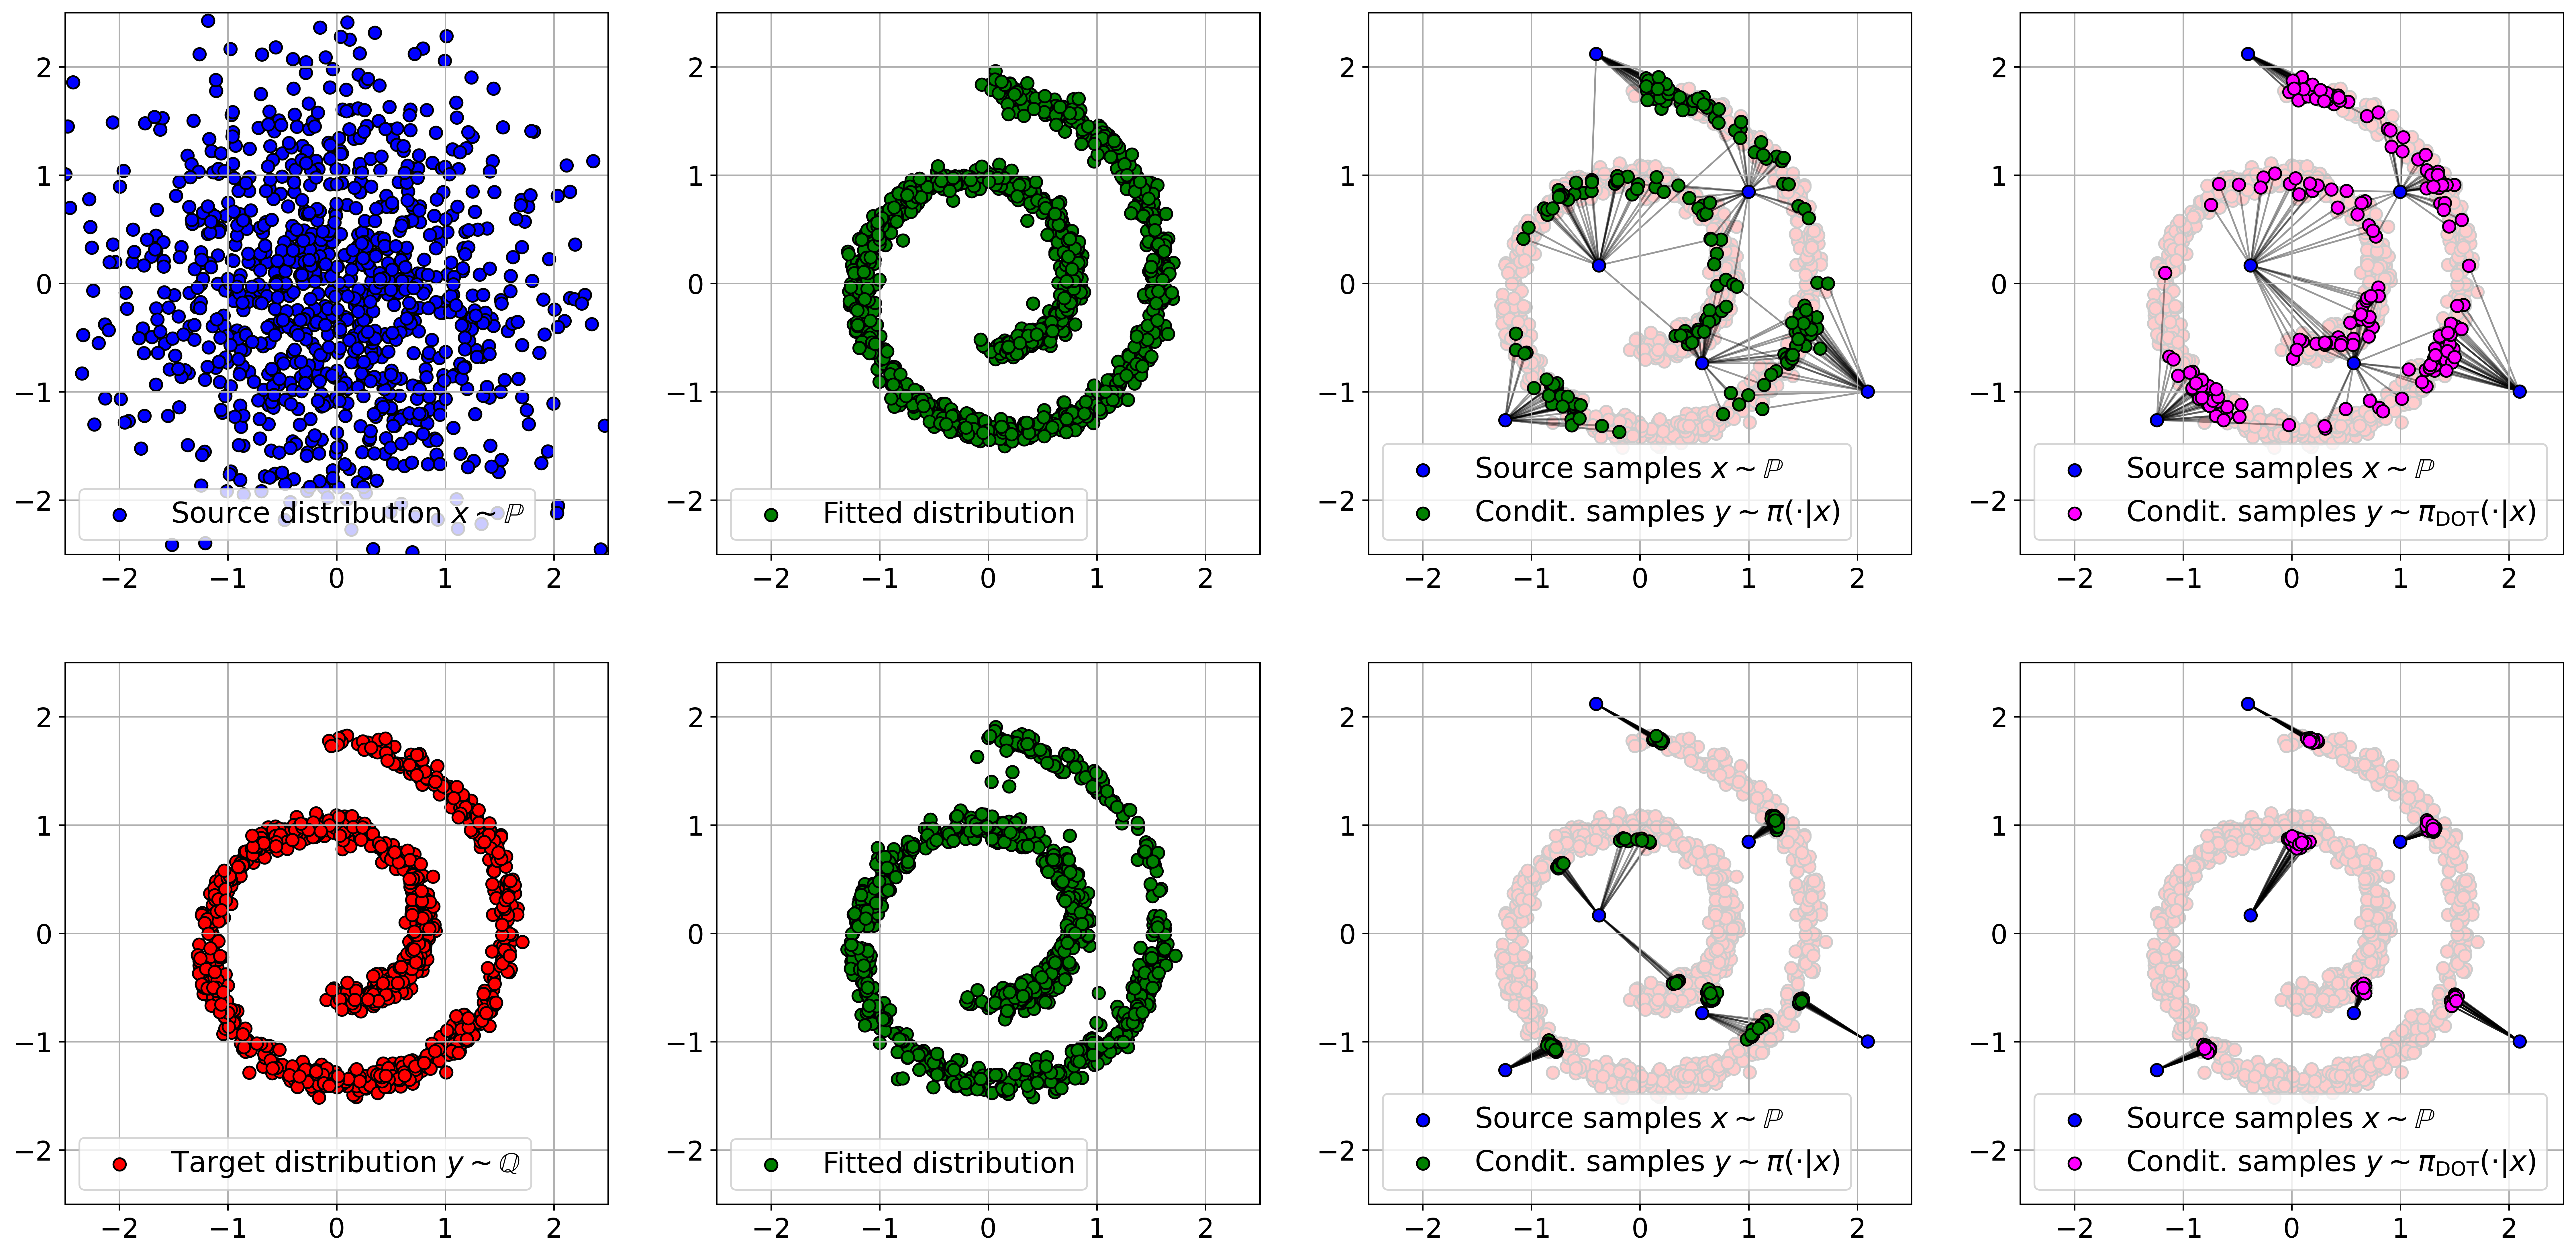

In [7]:
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)
LEGEND_POSITION = 'lower left'

fig, axes = plt.subplots(2, 4, figsize=(25, 12), dpi=450)
original_dataset = StdGauss_sampler.sample(1000).cpu()
axes[0, 0].scatter(
    original_dataset.numpy()[:, 0], original_dataset.numpy()[:, 1],
    c="blue", s=48, edgecolors="black", label=r'Source distribution $x \sim \mathbb{P}$'
)
# axes[0, 0].set_title("Input distribution")
axes[0, 0].legend(loc=LEGEND_POSITION, fontsize=16)

target_dataset = SwissRoll_sampler.sample(1000).cpu()
axes[1, 0].scatter(
    target_dataset.numpy()[:, 0], target_dataset.numpy()[:, 1],
    c="red", s=48, edgecolors="black", label = r"Target distribution $y \sim \mathbb{Q}$"
)
# axes[1, 0].set_title("Target distribution")
axes[1, 0].legend(loc=LEGEND_POSITION, fontsize=16)

HREGS = [0.1, 0.001]

DISCRETE_EOT_POINTS_TO_TRANSFER = [0, 1, 300, 10, 639, 677]
# DISCRETE_EOT_POINTS_TO_TRANSFER = [677]
N_TARGET_POINTS_PER_SOURCE = 30

for n, hreg in enumerate(HREGS):

    energy_model = load_energy_eot(hreg)
    discrete_model = load_discrete_eot(hreg)

    # dataset transfer
    basic_noise_gen = energy_model.sample_buffer.noise_gen
    transfered_dataset = energy_model.sample(
        original_dataset.to(DEVICE),
        n_iterations=20000,
        init_sampler=Distrib2Sampler(basic_noise_gen)).cpu()
    axes[n, 1].scatter(
        transfered_dataset.numpy()[:, 0], transfered_dataset.numpy()[:, 1],
        c="green", s=48, edgecolors="black", label = "Fitted distribution"
    )
    axes[n, 1].legend(loc=LEGEND_POSITION, fontsize=16)
    # axes[n, 1].set_title(r"$\bf{Ours}$, Fitted distribution, $\epsilon=$ "+ f"{hreg}")

    discrete_original_dataset = discrete_model.X

    for i_col in [2, 3]:
        axes[n, i_col].scatter(
            target_dataset.numpy()[:, 0], target_dataset.numpy()[:, 1],
            color=alpha_color('red'), s=48, edgecolors=alpha_color('black'), zorder=0
        )
        points_to_transfer = torch.stack([
            discrete_original_dataset[pt_index] for pt_index in DISCRETE_EOT_POINTS_TO_TRANSFER]).cpu().numpy()
        axes[n, i_col].scatter(
            points_to_transfer[:, 0], points_to_transfer[:, 1],
            c="blue", s=48, edgecolors="black", zorder=2, label=r'Source samples $x \sim \mathbb{P}$'
        )
    for __i, pt_index in enumerate(DISCRETE_EOT_POINTS_TO_TRANSFER):

        X_rep = discrete_original_dataset[
            pt_index].unsqueeze(0).repeat_interleave(N_TARGET_POINTS_PER_SOURCE, 0).to(DEVICE)

        Y_discr = discrete_model.sample_by_index(pt_index, N_TARGET_POINTS_PER_SOURCE)

        Y_eot = energy_model.sample(
            X_rep, n_iterations=20000, init_sampler=Distrib2Sampler(basic_noise_gen)).cpu().numpy()

        X_rep_np = X_rep.cpu().numpy()

        lines_energy = np.concatenate([X_rep_np, Y_eot], axis=-1).reshape(-1, 2, 2)
        lc_energy = matplotlib.collections.LineCollection(
            lines_energy, color='black', linewidths=1., alpha=0.4, zorder=1)
        axes[n, 2].add_collection(lc_energy)

        axes[n, 2].scatter(
            Y_eot[:, 0], Y_eot[:, 1],
            c="green", s=48, edgecolors="black", zorder=2, label=r'Condit. samples $y \sim \pi(\cdot \vert x)$' if __i == 0 else None
        )
        axes[n, 2].legend(loc=LEGEND_POSITION, fontsize=16)

        lines_discrete = np.concatenate([X_rep_np, Y_discr.numpy()], axis=-1).reshape(-1, 2, 2)
        lc_discrete = matplotlib.collections.LineCollection(
            lines_discrete, color='black', linewidths=1., alpha=0.4, zorder=1)
        axes[n, 3].add_collection(lc_discrete)
        axes[n, 3].scatter(
            Y_discr[:, 0], Y_discr[:, 1],
            c="magenta", s=48, edgecolors="black", zorder=2, label=r'Condit. samples $y \sim \pi_{\mathrm{DOT}}(\cdot \vert x)$' if __i == 0 else None
        )
        axes[n, 3].legend(loc=LEGEND_POSITION, fontsize=16)
    # axes[n, 2].set_title(r"$\bf{Ours}$, Fitted stochastic map, $\epsilon=$ "+ f"{hreg}")
    # axes[n, 3].set_title(r"Discrete EOT, Fitted stochastic map, $\epsilon=$ "+ f"{hreg}")


for i in range(8):
    axes[i%2, i//2].grid()
    axes[i%2, i//2].set_xlim([-2.5, 2.5])
    axes[i%2, i//2].set_ylim([-2.5, 2.5])

# plt.savefig(f"EnergyNOT_2D_camera_ready.svg")